In [1]:
!pip install yacs
!pip install gdown

In [2]:
import os, sys, time
import argparse
import importlib
from tqdm.notebook import tqdm
from imageio import imread
import torch
import numpy as np
import matplotlib.pyplot as plt

### Download pretrained
- We use HoHoNet w/ hardnet encoder in this demo
- Download other version [here](https://drive.google.com/drive/folders/1raT3vRXnQXRAQuYq36dE-93xFc_hgkTQ?usp=sharing)

In [3]:
PRETRAINED_PTH = 'ckpt/mp3d_depth_HOHO_depth_dct_efficienthc_TransEn1_hardnet/ep60.pth'

if not os.path.exists(PRETRAINED_PTH):
    os.makedirs(os.path.split(PRETRAINED_PTH)[0], exist_ok=True)
    !gdown 'https://drive.google.com/uc?id=1kZFPwdo36Uk7qP96yYUyQebZtGjsEabL' -O $PRETRAINED_PTH

### Download image
- We use a out-of-distribution image from PanoContext

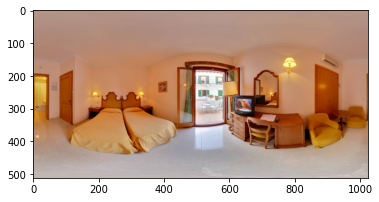

In [4]:
if not os.path.exists('assets/pano_asmasuxybohhcj.png'):
    !gdown 'https://drive.google.com/uc?id=1CXl6RPK6yPRFXxsa5OisHV9KwyRcejHu' -O 'assets/pano_asmasuxybohhcj.png'

rgb = imread('assets/pano_asmasuxybohhcj.png')

plt.imshow(rgb)
plt.show()

### Load model config
- We use HoHoNet w/ hardnet encoder in this demo
- Find out other version in `mp3d_depth/` and `s2d3d_depth`

In [5]:
from lib.config import config

config.defrost()
config.merge_from_file('config/mp3d_depth/HOHO_depth_dct_efficienthc_TransEn1_hardnet.yaml')
config.model.kwargs['backbone_config']['kwargs']['pretrained'] = False
config.freeze()

### Load model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('devcie:', device)

model_file = importlib.import_module(config.model.file)
model_class = getattr(model_file, config.model.modelclass)
net = model_class(**config.model.kwargs)
net.load_state_dict(torch.load(PRETRAINED_PTH, map_location=device))
net = net.eval().to(device)

devcie: cpu


### Move image into tensor, normzlie to [0, 255], resize to 512x1024

In [7]:
x = torch.from_numpy(rgb).permute(2,0,1)[None].float() / 255.
if x.shape[2:] != config.dataset.common_kwargs.hw:
    x = torch.nn.functional.interpolate(x, config.dataset.common_kwargs.hw, mode='area')
x = x.to(device)

### Model feedforward

In [8]:
with torch.no_grad():
    ts = time.time()
    pred_depth = net.infer(x)
    if not torch.is_tensor(pred_depth):
        pred_depth = pred_depth.pop('depth')
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(f'Eps time: {time.time() - ts:.2f} sec.')

Eps time: 3.09 sec.


### Visualize result in 2d

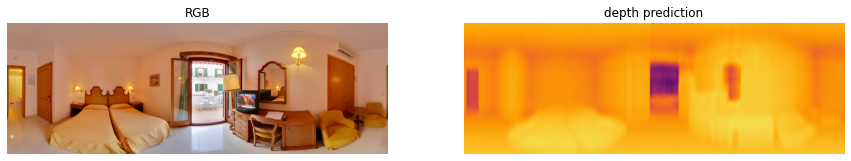

In [9]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.imshow(rgb[80:-80])
plt.axis('off')
plt.title('RGB')

plt.subplot(122)
plt.imshow(
    pred_depth.squeeze()[80:-80].cpu().numpy(),
    cmap='inferno_r', vmin=0.1, vmax=10)
plt.axis('off')
plt.title('depth prediction')

plt.show()

### Visualize result in 3d

In [ ]:
!pip install open3d
!pip install plotly

In [ ]:
import open3d as o3d
import plotly.graph_objects as go

In [ ]:
def get_uni_sphere_xyz(H, W):
    j, i = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    u = (i+0.5) / W * 2 * np.pi
    v = ((j+0.5) / H - 0.5) * np.pi
    z = -np.sin(v)
    c = np.cos(v)
    y = c * np.sin(u)
    x = c * np.cos(u)
    sphere_xyz = np.stack([x, y, z], -1)
    return sphere_xyz

In [ ]:
d = pred_depth.squeeze().cpu().unsqueeze(-1).numpy()
xyz = d * get_uni_sphere_xyz(*pred_depth.shape[2:])
xyzrgb = np.concatenate([xyz, rgb/255], -1)[80:-80][::2, ::2].reshape(-1, 6)
xyzrgb = xyzrgb[xyzrgb[:,2] < 1.5]

In [ ]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=xyzrgb[:,0], y=xyzrgb[:,1], z=xyzrgb[:,2], 
            mode='markers',
            marker=dict(size=1, color=xyzrgb[:,3:]),
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False, range=[-3,3]),
            yaxis=dict(visible=False, range=[-3,3]),
            zaxis=dict(visible=False, range=[-3,3]),
        ),
    )
)
fig.show()